In [1]:
import planetary_computer
from pystac_client import Client
import stackstac
import xarray as xr
import rioxarray as rio
import numpy as np
import pandas as pd
import geopandas as gpd
import os


import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rio
from rasterio.features import rasterize
from rasterio.enums import Resampling

from shapely import Point
import math as math

import pandas as pd
from pathlib import Path
from pystac_client import Client
import folium
import gc

root = Path.cwd()

In [ ]:
class EviTracker():
    def __init__(self,boundary,species,tree_layer,year,output_filepath):
        self.boundary = boundary
        self.species = species
        self.tree_layer = tree_layer
        self.year = year
        self.output_filepath = output_filepath

        if self.boundary.crs.to_epsg() != 26918:
             self.boundary = self.boundary.to_crs(26918)

    def find_imagery(self,m1,m2):  
        self.m1 = m1

        self.bbox_4326 = tuple(self.boundary.to_crs(4326).total_bounds)
        self.bbox_utm = tuple(self.boundary.total_bounds)

        catalog = Client.open(
                "https://planetarycomputer.microsoft.com/api/stac/v1",
                modifier=planetary_computer.sign_inplace,
            )
               

        items = catalog.search(
            bbox=self.bbox_4326,
            collections=["sentinel-2-l2a"],
            datetime=f"{self.year}-{m1}-01/{self.year}-{m2}-30",
            query= {"eo:cloud_cover":{"lt":20}} #"s2:mgrs_tile": {"eq": tile_id},
        ).item_collection()
        
        print(f'found {len(items)} images:')
        for feature in items:
            cloud_cover = feature.properties.get("eo:cloud_cover", "N/A")
            baseline = feature.properties.get("s2:processing_baseline")
            print(f"Scene {feature.id} - Cloud cover: {cloud_cover}%, Baseline: {baseline}")

        self.items = items
        
    def extract_evi(self,harmonize=False):
            
        stack = stackstac.stack(
            self.items,
            epsg=26918,
            resolution=10,
            bounds=self.bbox_utm,
            assets=['B02','B04','B8A','SCL']).where(lambda x: x > 0, other=np.nan)

       
        # crop to boundary
        stack = stack.rio.clip(geometries=self.boundary.geometry)

        # set time coord to just the day 
        stack  = stack.assign_coords(time=stack['time'].dt.floor('D'))

        # group data from same day together (mosaics adjacent tiles)
        mosaic = stack.groupby('time').max(dim='time',skipna=True)
        print(f'number of days: {mosaic.sizes['time']}')

        scl_band = mosaic.sel(band='SCL')
        # saturated/defective, cloud shadows, water, cloud medium, cloud high, cirrus, snow
        masked = mosaic.where(~scl_band.isin([1, 3, 6, 8, 9, 10, 11]))
        
        # drop SCL band
        masked = masked.drop_sel(band='SCL')

        self.masked_data = masked

        
        # if old baseline, apply offset factor to align with newer baselines (4.0+)
        if harmonize:
            scaled = (masked + 1000) / 10000  
            scaled = scaled.clip(min=0,max=1)
        else: 
            scaled = masked / 10000
            scaled = scaled.clip(min=0,max=1)
    
        red = scaled.sel(band="B04")
        blue = scaled.sel(band='B02')
        nir = scaled.sel(band='B8A')

        # compute evi
        denominator = nir + 6 * red - 7.5 * blue + 1
        evi = 2.5 * ((nir - red) / denominator)
        #evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))
        evi = evi.clip(min=-1,max=1)
        # create median composite
        evi = evi.median('time')

        # make sure rasters are aligned, reproject if not
        if evi.rio.crs == self.tree_layer.rio.crs and evi.rio.resolution() == self.tree_layer.rio.resolution() and np.array_equal(evi.x, self.tree_layer.x) and np.array_equal(evi.y, self.tree_layer.y):
            tree_mask = self.tree_layer
        else:
            print('reprojecting tree layer')
            tree_mask = self.tree_layer.rio.reproject_match(evi, resampling=Resampling.bilinear)
            
            
        
        # filter for just target tree species
        evi_masked = evi.where(tree_mask.isel(band=0).notnull())

        # write to tif
        evi_masked.rio.to_raster(self.output_filepath / f'{self.species}_evi_{self.year}_sentinel_{self.m1}.tif')
        print(f'{self.year} {self.species} evi save to {self.output_filepath} / {self.species}_evi_{self.year}_sentinel_{self.m1}.tif')

In [5]:
root = Path.cwd()
boundary = gpd.read_file(root / 'catskills' / 'catskills_boundary.gpkg')
#tree_layer = xr.open_dataarray(root / 'hemlock' / 'hemlock_extent_2021_utm_10m.tif')
output_filepath = root / 'sentinel_data' / 'catskills' 

In [3]:
tree_layer = xr.open_dataarray(root / 'sentinel_data' / 'catskills' / 'predictions_mosaic.tif')
tree_layer = tree_layer.where(tree_layer>=0.8)

In [11]:
tree_layer.rio.to_raster(root / 'sentinel_data' / 'catskills' / 'beech_extent_80pctprob.tif')

In [9]:
#hemlock = EviTracker(boundary=boundary,tree_layer=tree_layer,year=2016,output_filepath=output_filepath)

beech = EviTracker(boundary=boundary,species='beech',tree_layer=tree_layer,year=2024,output_filepath=output_filepath)


beech.find_imagery(m1='07',m2='08')

#hemlock.extract_evi()

found 6 images:
Scene S2A_MSIL2A_20240827T154931_R054_T18TWM_20240827T221452 - Cloud cover: 5.851104%, Baseline: 05.11
Scene S2A_MSIL2A_20240827T154931_R054_T18TWM_20240827T214948 - Cloud cover: 2.998345%, Baseline: 05.11
Scene S2A_MSIL2A_20240827T154931_R054_T18TVM_20240827T221452 - Cloud cover: 2.519192%, Baseline: 05.11
Scene S2A_MSIL2A_20240824T153931_R011_T18TWM_20240824T221958 - Cloud cover: 14.052601%, Baseline: 05.11
Scene S2A_MSIL2A_20240814T153941_R011_T18TWM_20240814T223950 - Cloud cover: 15.196332%, Baseline: 05.11
Scene S2A_MSIL2A_20240728T154941_R054_T18TVM_20240728T235651 - Cloud cover: 8.811278%, Baseline: 05.11


In [10]:
beech.extract_evi()

number of days: 4
2024 beech evi save to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree\sentinel_data\catskills / beech_evi_2024_sentinel_07.tif


In [12]:
beech_2022 = xr.open_dataarray(root / 'sentinel_data' / 'catskills' / 'beech_evi_2022_sentinel_07.tif')
beech_2024 = xr.open_dataarray(root / 'sentinel_data' / 'catskills' / 'beech_evi_2024_sentinel_07.tif')

In [13]:
diff = beech_2024 - beech_2022

In [17]:
np.nanmean(diff)

np.float64(-0.05321603453576693)

In [14]:
diff.rio.to_raster(root / 'sentinel_data' / 'catskills' / 'diff_evi_2022_2024.tif')

In [64]:
hemlock_2021 = xr.open_dataarray(root / 'hemlock' / 'hemlock_evi_2021_sentinel_november.tif')
hemlock_2016 = xr.open_dataarray(root / 'hemlock' / 'hemlock_evi_2017_sentinel_november.tif')

In [71]:
diff_17_21 = xr.open_dataarray(root / 'hemlock' / 'diff_2017_2021_sentinel_november.tif')

np.nanmean(diff_17_21)

np.float64(-0.0019628819544040164)

In [72]:
print(f'2021:{np.nanmean(hemlock_2021)}, 2016: {np.nanmean(hemlock_2016)}')

2021:0.2970052620398803, 2016: 0.2989838050854756


In [65]:
diff = hemlock_2021 - hemlock_2016

In [66]:
diff.rio.to_raster(root / 'hemlock' / 'diff_2017_2021_sentinel_november.tif')

In [ ]:
# continuous conifer raster

extent_2021 = xr.open_dataarray(root / 'hemlock' / 'hemlock_extent_2021.tif')
extent_2021 = xr.where(extent_2021 == 2, 1, 0)
extent_2021 = extent_2021.rio.write_crs(6537).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()
extent_2021 = extent_2021.astype('float32')
percent_hemlock = extent_2021.rio.reproject_match(diff,resampling=Resampling.average)

percent_hemlock.rio.to_raster(root / 'hemlock' / 'percent_hemlock_2021.tif')

In [49]:
evi_2016 = xr.open_dataarray(root / 'hemlock' / 'hemlock_evi_2016_sentinel_november.tif')
evi_2021 = xr.open_dataarray(root / 'hemlock' / 'hemlock_evi_2021_sentinel_november.tif')
#evi_2024 = xr.open_dataarray(root / 'hemlock' / 'hemlock_evi_2024_sentinel_november_notoffset.tif')

cc = xr.open_dataarray(root / 'hemlock' / 'percent_hemlock_2021.tif')

In [50]:
t = xr.concat([evi_2016,evi_2021,cc],dim='band')

In [52]:


evi_2016 = t.isel(band=0).values
evi_2021 = t.isel(band=1).values
hemlock = t.isel(band=2).values

# Flatten to 1D arrays
evi_2016_flat = evi_2016.ravel()
evi_2021_flat = evi_2021.ravel()
hemlock_flat = hemlock.ravel()

# Create DataFrame
df = pd.DataFrame({
    "EVI_2016": evi_2016_flat,
    "EVI_2021": evi_2021_flat,
    "Percent_Hemlock": hemlock_flat
})

df = df.dropna()

df['Percent_Hemlock'] = df['Percent_Hemlock'] * 100

In [53]:
bins = [0, 25, 50, 75, 100]
labels = ["0-25%", "25-50%", "50-75%", "75-100%"]
df["Hemlock_Bin"] = pd.cut(df["Percent_Hemlock"], bins=bins, labels=labels, include_lowest=True)

df_long = df.melt(
    id_vars="Hemlock_Bin",
    value_vars=["EVI_2016", "EVI_2021"],
    var_name="Year",
    value_name="EVI"
)

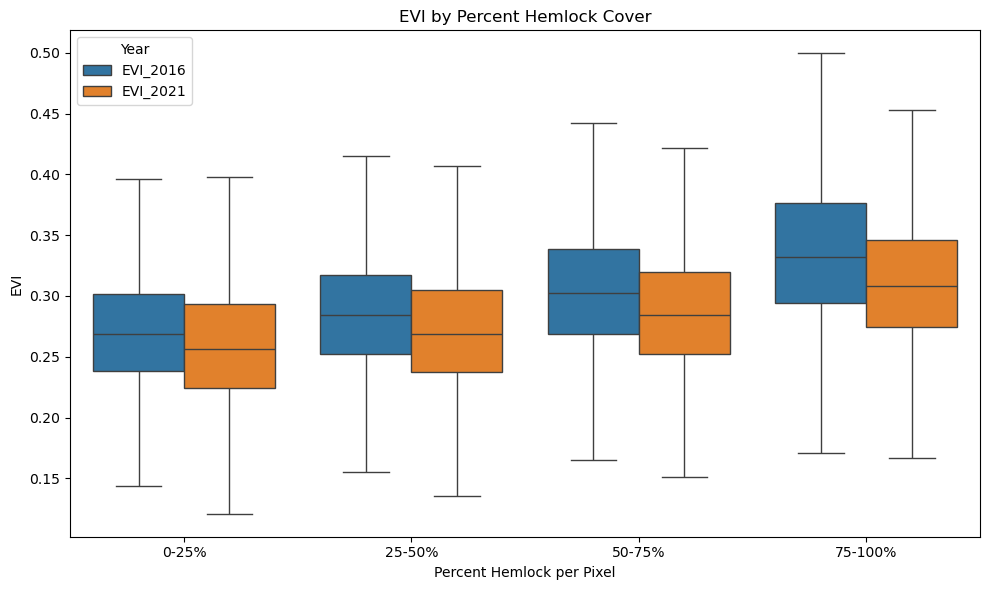

In [58]:
plt.figure(figsize=(10,6))
import seaborn as sns
sns.boxplot(data=df_long, x="Hemlock_Bin", y="EVI", hue="Year", showfliers=False)

plt.xlabel("Percent Hemlock per Pixel")
plt.ylabel("EVI")
plt.title("EVI by Percent Hemlock Cover")
plt.legend(title="Year", loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
## landsat
# class EviTracker():
#     def __init__(self,boundary,tree_layer,year,output_filepath):
#         self.boundary = boundary
#         self.tree_layer = tree_layer
#         self.year = year
#         self.output_filepath = output_filepath

#         if self.boundary.crs.to_epsg() != 26918:
#              self.boundary = self.boundary.to_crs(26918)

#     def get_cloud_mask(self, a):
#         mask_values= np.unique(a.sel(band='qa_pixel'))
        
#         # same bits for Landsat 5, 7, 8 & 9
#         CLOUD = 1 << 3
#         CLOUD_SHADOW = 1 << 4
#         SNOW = 1 << 5

#         keep_values = list()
#         for v in mask_values[:-1]:
#                 v_int = int(v)
#                 if ((v_int & CLOUD) == 0) and ((v_int & CLOUD_SHADOW) == 0) and ((v_int & SNOW) == 0):
#                         keep_values.append(v)

#         return keep_values

#     def extract_evi(self,harmonize=True):  # harmonize = True makes data from after 2014 comparable to data before 2014

#         bbox_4326 = tuple(self.boundary.to_crs(4326).total_bounds)
#         bbox_utm = tuple(self.boundary.total_bounds)

#         catalog = Client.open(
#             "https://planetarycomputer.microsoft.com/api/stac/v1",
#             modifier=planetary_computer.sign_inplace,
#         )

#         if self.year <= 2014:
#             platform = {"in": ["landsat-7"]} # avoid landsat 5 TM sensor
#         else:
#             platform =  {"in": ["landsat-8", "landsat-9"]} # avoid landsat 7 

#         items = catalog.search(
#             bbox=bbox_4326,
#             collections=["landsat-c2-l2"],
#             datetime=f"{self.year-1}-11-01/{self.year}-03-31",
#             query= {"eo:cloud_cover":{"lt":20},
#                     "platform": platform} 
#         ).item_collection()

#         print(f'found {len(items)} images:')
#         for feature in items:
#             cloud_cover = feature.properties.get("eo:cloud_cover", "N/A")
#             print(f"Scene {feature.id} - Cloud cover: {cloud_cover}%")

#         stack = stackstac.stack(
#                     items,
#                     epsg=26918,
#                     resolution=30,
#                     bounds=bbox_utm,
#                     assets=["nir08", "red","blue", "qa_pixel"]).where(lambda x: x > 0, other=np.nan)

                    
#         # crop to boundary
#         stack = stack.rio.clip(geometries=self.boundary.geometry)

#         # get cloud mask
#         cloud_mask = self.get_cloud_mask(stack)
#         qa_band = stack.sel(band='qa_pixel')
#         valid = qa_band.isin(cloud_mask) 
#         # apply cloud mask
#         masked = stack.where(valid)

#         # convert to float32 to save memory
#         masked = masked.astype('float32')

#         red = masked.sel(band="red")
#         blue = masked.sel(band='blue')
#         nir = masked.sel(band='nir08')

#         # harmonize ETM to OLI
#         # coefficients from Roy (2016)
#         # blue: OLI = 0.0173 + 0.8707 ETM +
#         # red: OLI = 0.0107 + 0.9175 ETM +
#         # nir08: OLI = 0.0374 + 0.9281 ETM +

#         if self.year < 2014 and harmonize is True:
#              blue = 0.0173 + 0.8707 * blue
#              red = 0.0107 + 0.9175 * red
#              nir = 0.0374 + 0.9281 * nir
             
#         # compute evi
#         denominator = nir + 6 * red - 7.5 * blue + 1
#         evi = 2.5 * ((nir - red) / denominator)
#         #evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))
#         evi = evi.clip(min=-1,max=1)
#         # create median composite
#         evi = evi.median('time')

#         # make sure rasters are aligned, reproject if not
#         if evi.rio.crs == self.tree_layer.rio.crs and evi.rio.resolution() == self.tree_layer.rio.resolution() and np.array_equal(evi.x, self.tree_layer.x) and np.array_equal(evi.y, self.tree_layer.y):
#             tree_mask = self.tree_layer
#         else:
#             tree_mask = self.tree_layer.rio.reproject_match(evi, resampling=Resampling.bilinear)
        
#         # filter for just target tree species
#         evi_masked = evi.where(tree_mask.isel(band=0).notnull())

#         # write to tif
#         evi_masked.rio.to_raster(self.output_filepath / f'hemlock_evi_{self.year}.tif')
#         print(f'{self.year} hemlock evi save to {self.output_filepath} / hemlock_evi_{self.year}.tif')
        